# Changes


try clipping gradients to reduce the size of weight updates after epoch 30:

Changed to 2x2 convs, with 2 stride?

Scale input to be between 0 - 1?


# Setup

In [22]:
import os
import glob
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils import data

from torch.autograd import Variable, Function

from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

from PIL import Image, ImageFilter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# Constants

In [23]:
BATCH_SIZE = 16
DATA_PATH= '/home/yvan/projects/data_sci_bowl_2018/data'
N_EPOCHS = 50
FILTER_DEPTH_IN, FILTER_DEPTH_OUT = 3, 3
IMG_SIZE = 512
LR = 0.001

# Re-creating datasets

In [24]:
# # create a train, test, validation datasets
# convert_raw_train(folder_name='stage1_train', 
#                   make_valid=True,
#                   rand_state=75)
# convert_raw_test(folder_name='stage1_test', folder_new='test_img')
dir_contents = [os.listdir(os.path.join(DATA_PATH, 'train_img', 'all')), os.listdir(os.path.join(DATA_PATH, 'valid_img', 'all'))]
list(map(len, dir_contents))

[603, 67]

# Data Processing

In [25]:
#create a custom imageloader that gets the name of the file as well
class YvanImageFolder(ImageFolder):
    def __getitem__(self,index):
        return super(YvanImageFolder, self).__getitem__(index), self.imgs[index]
    
class YvanDataset(data.Dataset):
    '''
    dataset wrapping image folders can't use default because 
    we need to load and transform target masks for segmentation!
    '''
    def __init__(self, img_path, target_path, transform=None, transform_target=None):
        self.imgs = sorted(glob.glob(os.path.join(img_path, '**/*.jpg')))
        self.targets = sorted(glob.glob(os.path.join(target_path, '**/*.jpg')))
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        img = Image.open(self.imgs[index])
        target = Image.open(self.targets[index])
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        np.random.seed(seed) 
        if self.transform:
            img = self.transform(img)
        np.random.seed(seed) 
        if self.transform_target:
            target = self.transform_target(target)
            
        return img, target, self.imgs[index], self.targets[index]
    
    def __len__(self):
        return len(self.imgs)
        
# train data
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
#     transforms.Grayscale(),
    transforms.ToTensor()
])

img_dataset = YvanDataset(os.path.join(DATA_PATH, 'train_img'),
                              os.path.join(DATA_PATH,'train_mask'),
                              transform=img_transform,
                              transform_target=target_transform)

img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

for (img, mask, name, target_name) in img_loader:
    a,b,name,target_name = img[3], mask[3], name[3], target_name[3]
    print(name, target_name)
    print(type(a),type(b))
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    timg = transforms.ToPILImage()(a.cpu())
    tmask = transforms.ToPILImage()(b.cpu())
    break

/home/yvan/projects/data_sci_bowl_2018/data/train_img/all/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed_img.jpg /home/yvan/projects/data_sci_bowl_2018/data/train_mask/all/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed_mask.jpg
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
torch.Size([3, 512, 512]) torch.Size([3, 512, 512])
0.8588235378265381 0.24313725531101227 1.0 0.0


In [26]:
valid_dataset = YvanDataset(os.path.join(DATA_PATH, 'valid_img'),
                              os.path.join(DATA_PATH,'valid_mask'),
                              transform=img_transform,
                              transform_target=target_transform)
valid_loader = data.DataLoader(dataset=valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

for (img, mask, name, target_name) in valid_loader:
    a,b,name,target_name = img[3], mask[3], name[3], target_name[3]
    print(name, target_name)
    print(type(a),type(b))
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    timg = transforms.ToPILImage()(a.cpu())
    tmask = transforms.ToPILImage()(b.cpu())
    break

/home/yvan/projects/data_sci_bowl_2018/data/valid_img/all/07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5_img.jpg /home/yvan/projects/data_sci_bowl_2018/data/valid_mask/all/07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5_mask.jpg
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
torch.Size([3, 512, 512]) torch.Size([3, 512, 512])
0.9372549057006836 0.05882352963089943 1.0 0.0


Ok so we can convert our stuff into tensors and convert them back into images.

# Unet model

referenced: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [27]:
### conv building block ###

class conv_block(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class conv_block_drop(nn.Module):
    def __init__(self, in_chan, out_chan, drop):
        super(conv_block_drop, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=drop),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.LeakyReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
### inputs and outputs ###

class in_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(in_conv, self).__init__()
        self.conv = conv_block(in_chan, out_chan)
        
    def forward(self, x):
        return self.conv(x)
        
class out_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(out_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_chan)
        self.conv = nn.Conv2d(in_chan, out_chan, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        return self.activation(self.conv(self.bn(x)))
    
### actual conv blocks ###

class conv_down(nn.Module):
    def __init__(self, in_chan, out_chan, drop):
        super(conv_down, self).__init__()
        self.conv = conv_block_drop(in_chan, out_chan, drop)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.pool(self.conv(x))
        return x

class conv_up(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_up, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block(2*out_chan, out_chan)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x
    
class conv_up_drop(nn.Module):
    def __init__(self, in_chan, out_chan, drop):
        super(conv_up_drop, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block_drop(2*out_chan, out_chan, drop)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x
    
class unet1(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(unet1, self).__init__()
        self.inc = in_conv(in_chan, 8)
        self.down0 = conv_down(8, 16, 0.1)
        self.down1 = conv_down(16, 32, 0.1)
        self.down2 = conv_down(32, 64, 0.1)
        self.down3 = conv_down(64, 128, 0.1)
        self.down4 = conv_down(128, 256, 0.2)
        self.down5 = conv_down(256, 512, 0.2)
        self.up1 = conv_up_drop(512, 256, 0.2)
        self.up2 = conv_up_drop(256, 128, 0.2)
        self.up3 = conv_up_drop(128, 64, 0.1)
        self.up4 = conv_up_drop(64, 32, 0.1)
        self.up5 = conv_up_drop(32, 16, 0.1)
        self.up6 = conv_up_drop(16, 8, 0.1)
        self.out = out_conv(8, out_chan)
        
    def forward(self, x):
        xn = self.inc(x)
        x0 = self.down0(xn)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.up5(x, x0)
        x = self.up6(x, xn)
        x = self.out(x)
        return x

In [28]:
# create a unet
unet = unet1(FILTER_DEPTH_IN, FILTER_DEPTH_OUT)
opti = optim.Adam(unet.parameters(), lr=LR, betas=(0.5,0.99))
sched = ReduceLROnPlateau(opti, mode='min', threshold=0.005, patience=5)
loss = BCEDiceLoss()

nparams = sum([param.nelement() for param in unet.parameters()])
psum = check_param_sum(unet)
print(f'creating model with {nparams} params and intial param sum {psum}')

if torch.cuda.is_available():
    unet.cuda()
    loss.cuda()

creating model with 7784465 params and intial param sum 1250.3131536580622


In [29]:
losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    epoch_loss = []
    e = epoch+1
    for (batch, mask_batch, _, _) in img_loader:
        image_batch = to_variable(batch)
        labels = to_variable(mask_batch)
        x = unet(image_batch)
        l = loss(x, labels)
        epoch_loss.append(l.data[0])
        unet.zero_grad()
        l.backward()
        opti.step()
        
    mean_epoch_loss = np.mean(epoch_loss)
    losses.append(mean_epoch_loss)

    valid_loss = []
    for (batch, mask_batch, _, _) in valid_loader:
        image_batch = to_variable(batch)
        labels = to_variable(mask_batch)
        freeze_model(unet)
        x = unet(image_batch)
        vl = loss(x, labels)
        unfreeze_model(unet)
        valid_loss.append(vl.data[0])
        
    mean_valid_loss = np.mean(valid_loss)
    valid_losses.append(mean_valid_loss)
    sched.step(mean_valid_loss)
    
    if not e % 5: 
        lr_t = opti.param_groups[0]['lr']
        print(f'lr is: {lr_t}')
        print(f'training epoch {e}, epoch loss {mean_epoch_loss}')
        print(f'training epoch {e}, epoch valid loss {mean_valid_loss}')
    epoch_loss = []
    valid_loss = []

lr is: 0.001
training epoch 5, epoch loss 0.5626335034244939
training epoch 5, epoch valid loss 0.5393368244171143
lr is: 0.001
training epoch 10, epoch loss 0.2778131036381972
training epoch 10, epoch valid loss 0.2860903024673462
lr is: 0.001
training epoch 15, epoch loss 0.16078463196754456
training epoch 15, epoch valid loss 0.19342920780181885
lr is: 0.001
training epoch 20, epoch loss 0.12533490595064664
training epoch 20, epoch valid loss 0.14966413974761963
lr is: 0.001
training epoch 25, epoch loss 0.1168958936866961
training epoch 25, epoch valid loss 0.15884337425231934
lr is: 0.001
training epoch 30, epoch loss 0.10869208135102924
training epoch 30, epoch valid loss 0.13047071695327758
lr is: 0.001
training epoch 35, epoch loss 0.10331367975787113
training epoch 35, epoch valid loss 0.13161467313766478
lr is: 0.0001
training epoch 40, epoch loss 0.09987249343018782
training epoch 40, epoch valid loss 0.12460939884185791
lr is: 0.0001
training epoch 45, epoch loss 0.09467144

lowest loss: 0.09294798029096503
lowest val loss: 0.12128125429153443


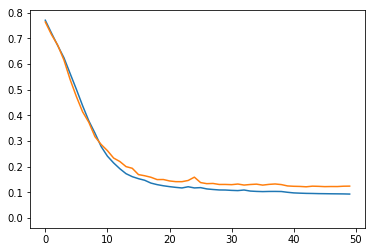

In [30]:
lowestloss = min(losses)
lowestvalid = min(valid_losses)
print(f'lowest loss: {lowestloss}')
print(f'lowest val loss: {lowestvalid}')
plt.plot(losses)
plt.plot(valid_losses)
plt.plot(np.linspace(0,25,1))
plt.show()

In [10]:
# model_file = 'models/model_feb252018_5:02.pkl'
# torch.save(unet, model_file)
# unet = torch.load(model_file)

# Examining Predictions

In [33]:
freeze_model(unet)
predicted_masks = []
actual_masks = []
names = []
unet.eval()
for (batch, mask_batch, batch_name, mask_name) in valid_loader:
    image_batch = to_variable(batch)
    labels = to_variable(mask_batch)
    names.extend(batch_name)
    x = unet(image_batch)
    for i, l in zip(x.data, labels.data):
        predicted_masks.append(transforms.ToPILImage(mode='RGB')(i.cpu()))
        actual_masks.append(transforms.ToPILImage(mode='RGB')(l.cpu()))
        
assert len(predicted_masks) == len(actual_masks)
assert len(predicted_masks) == len(names)

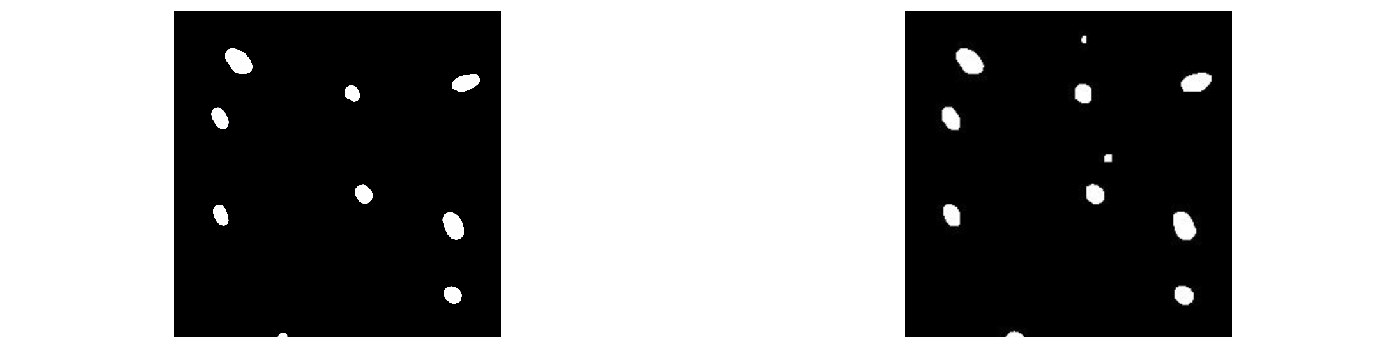

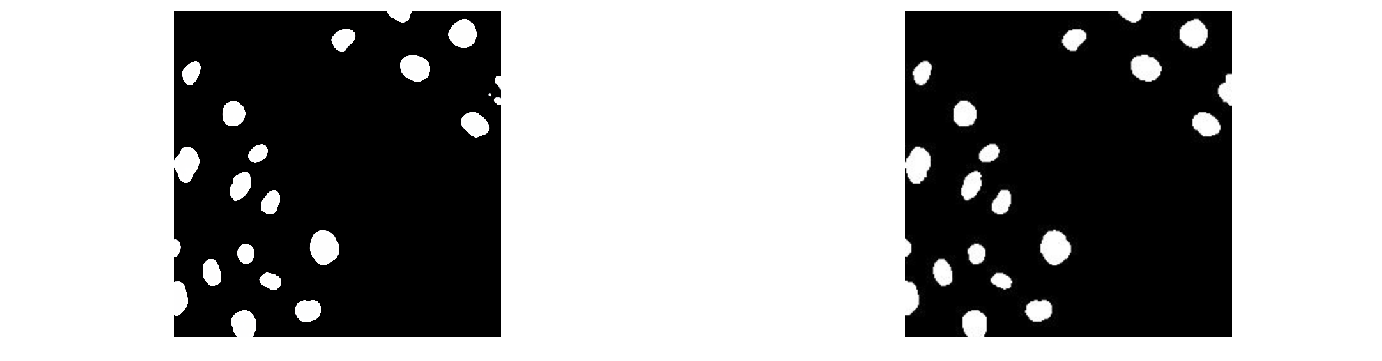

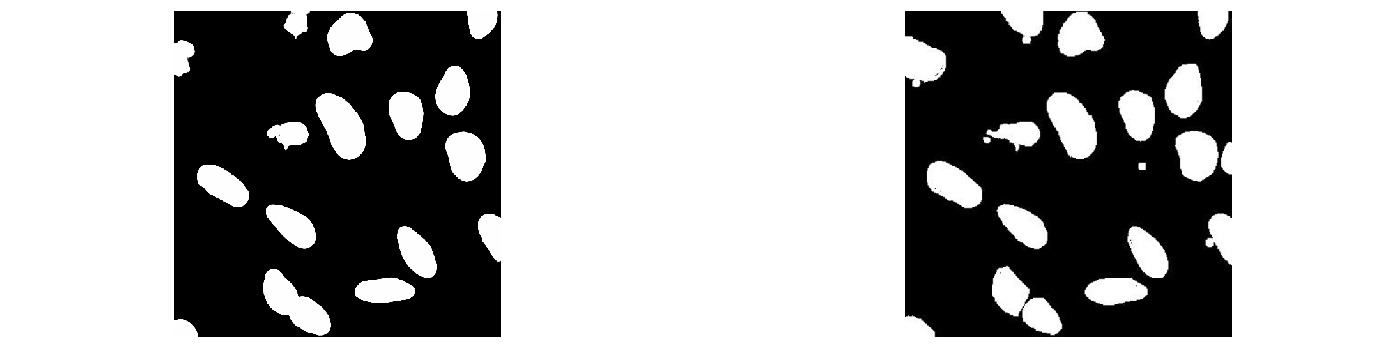

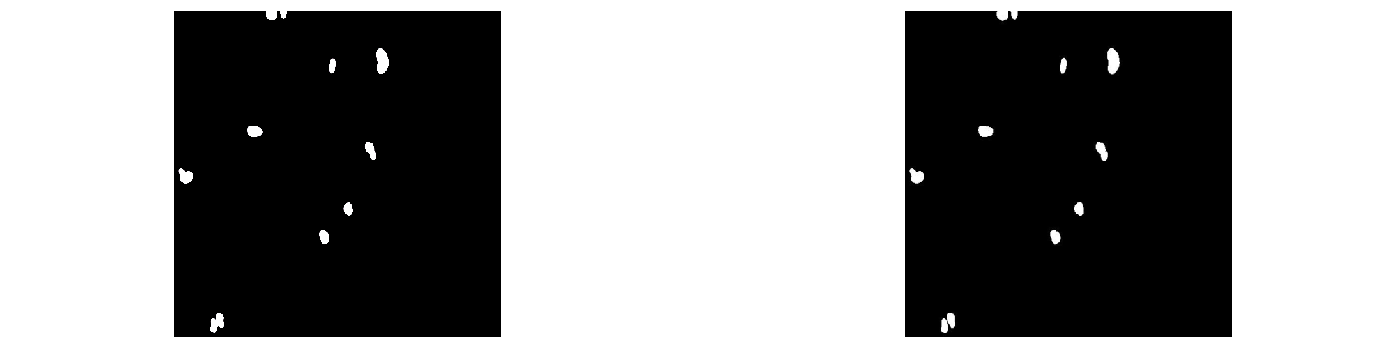

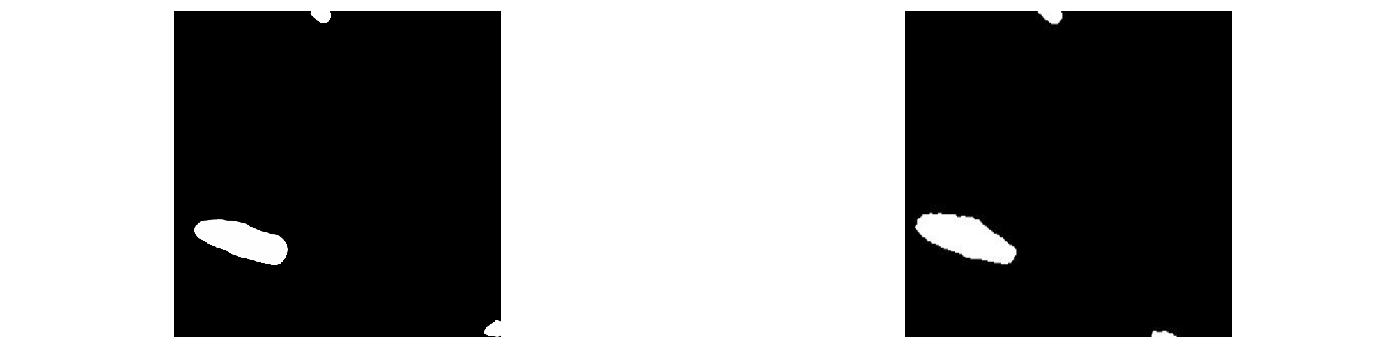

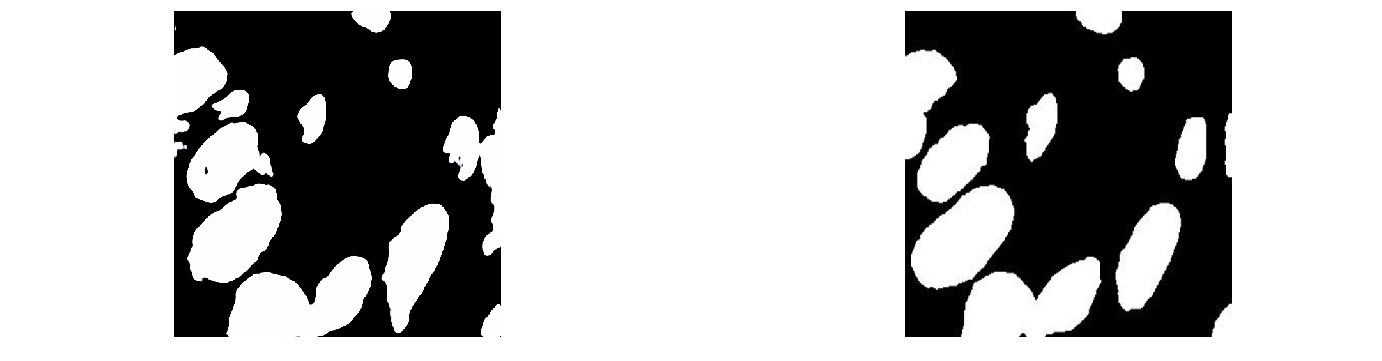

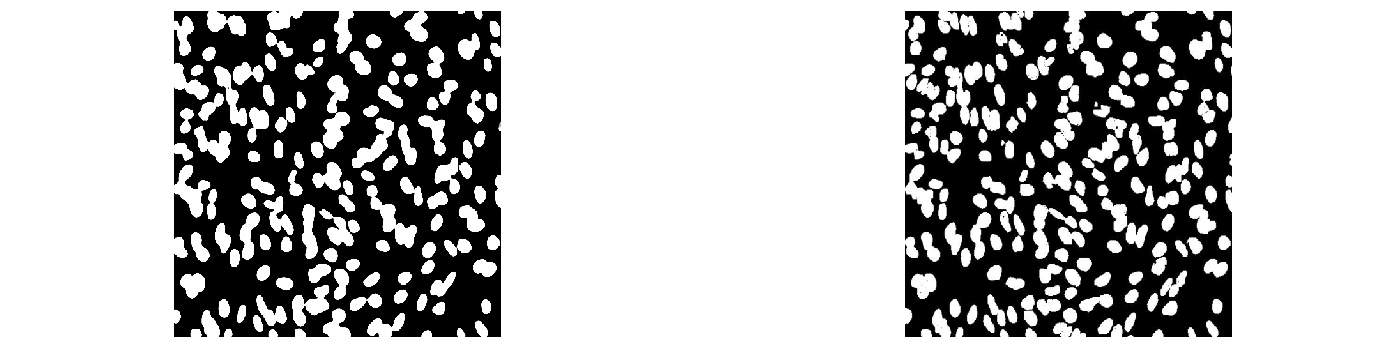

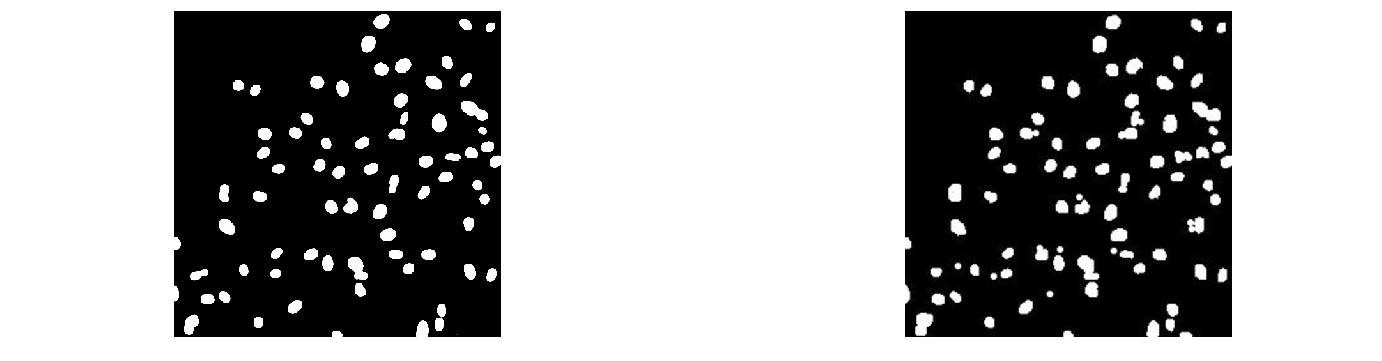

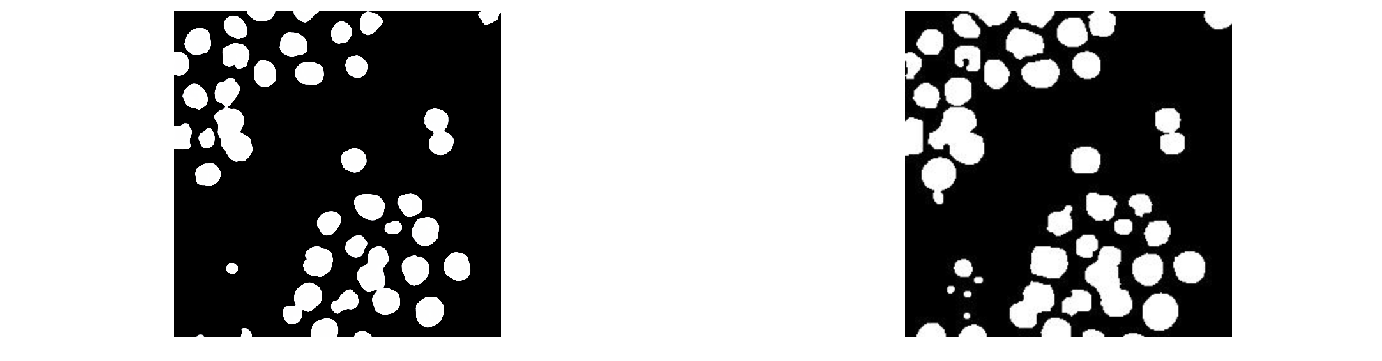

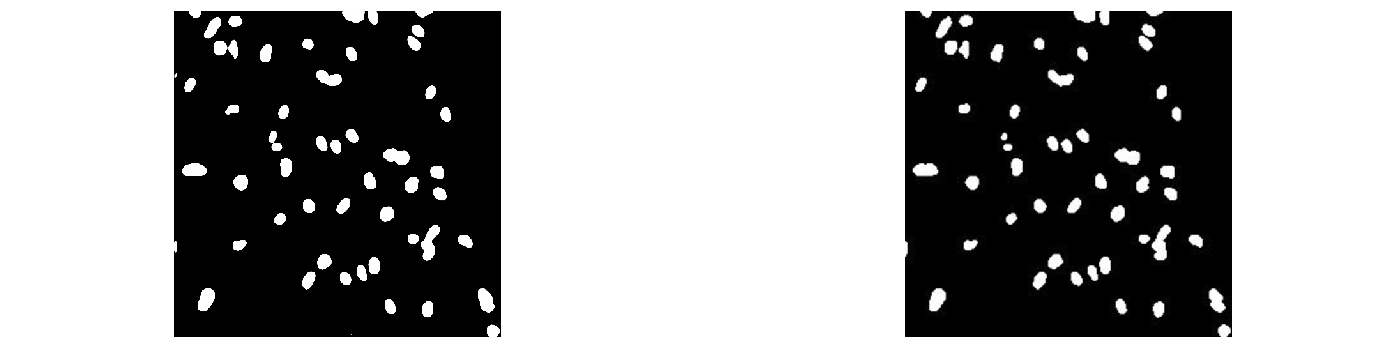

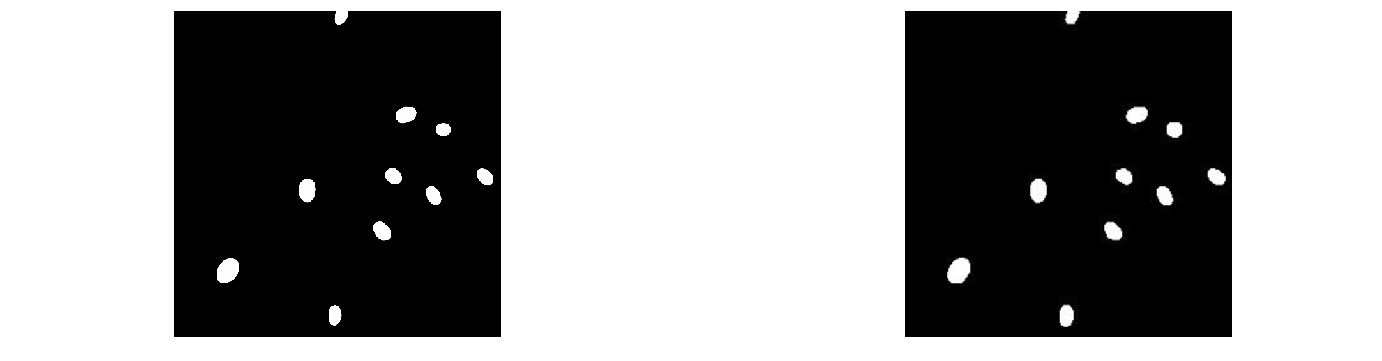

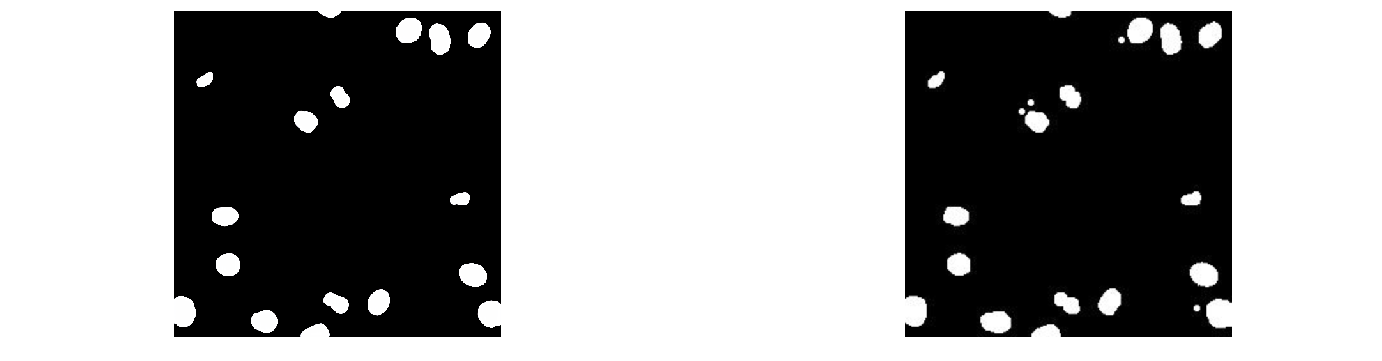

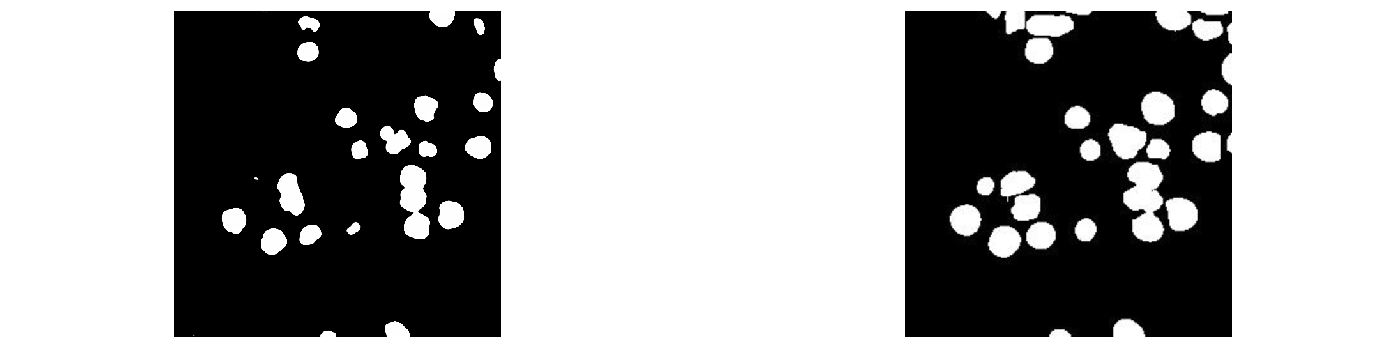

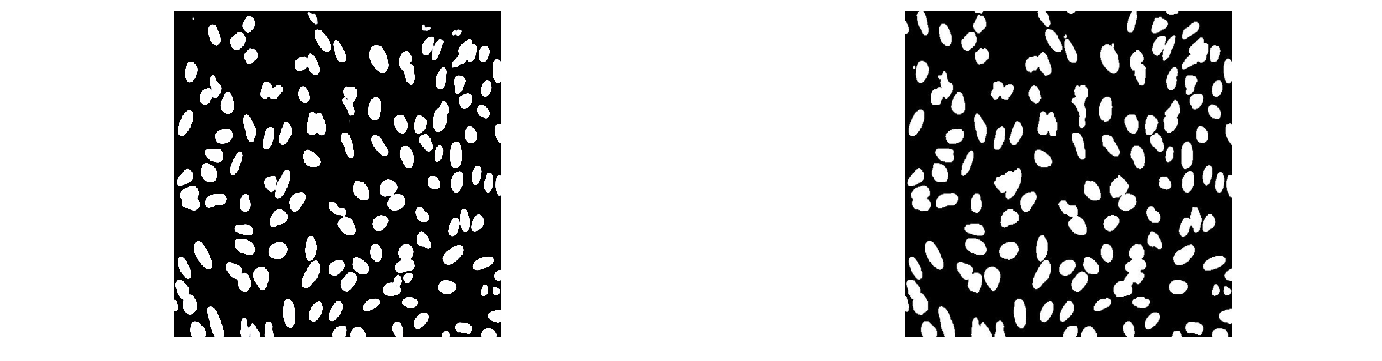

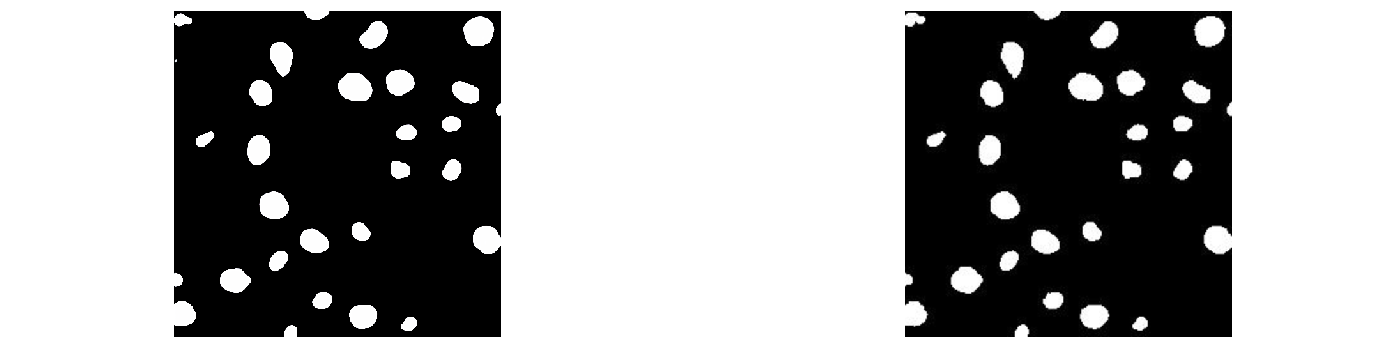

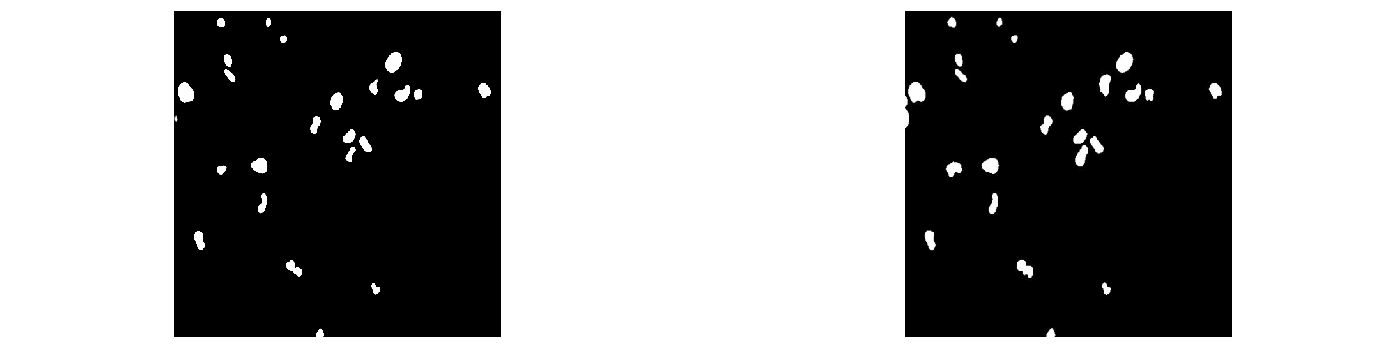

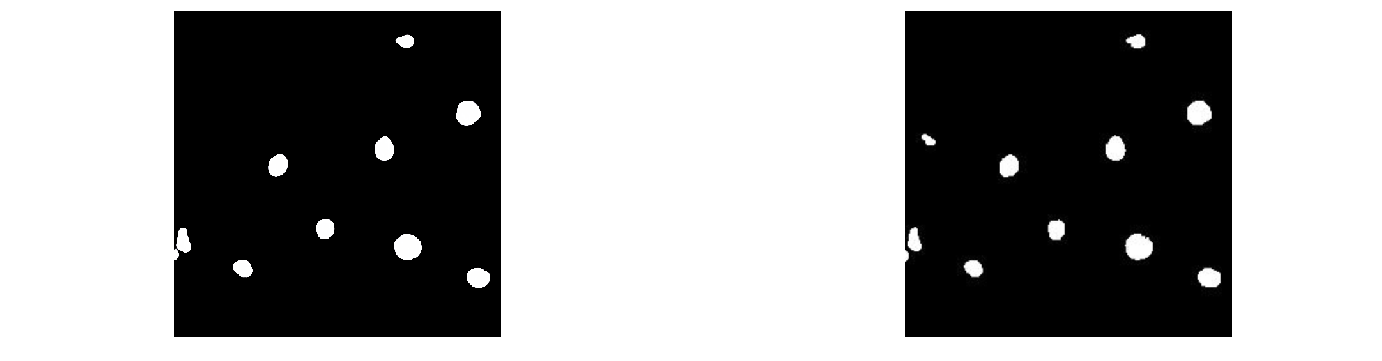

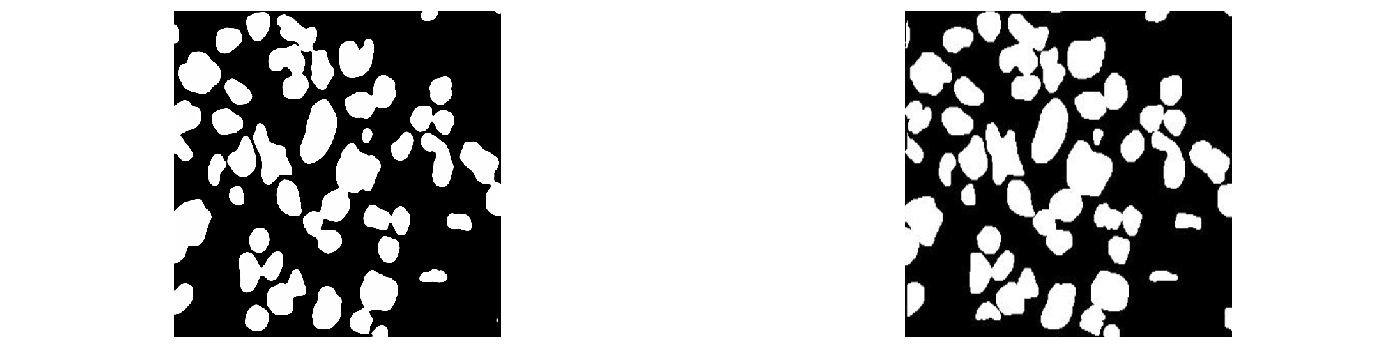

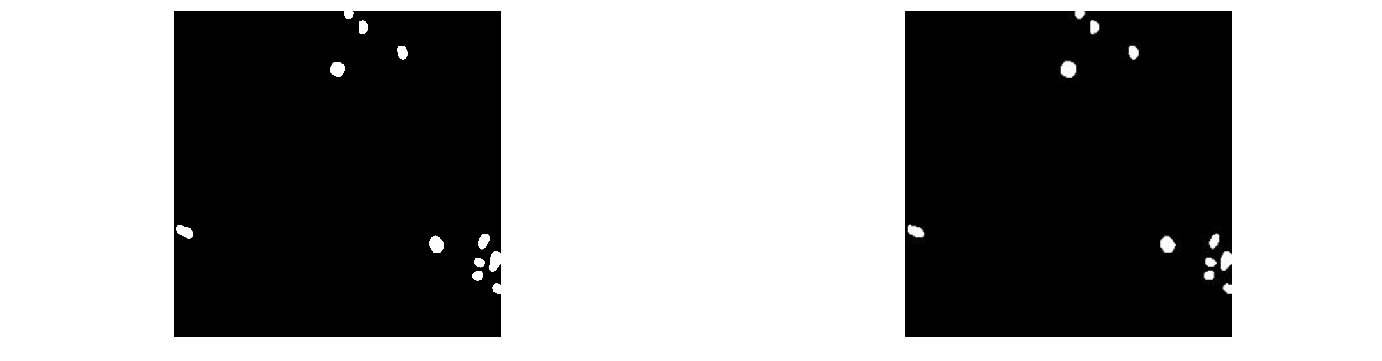

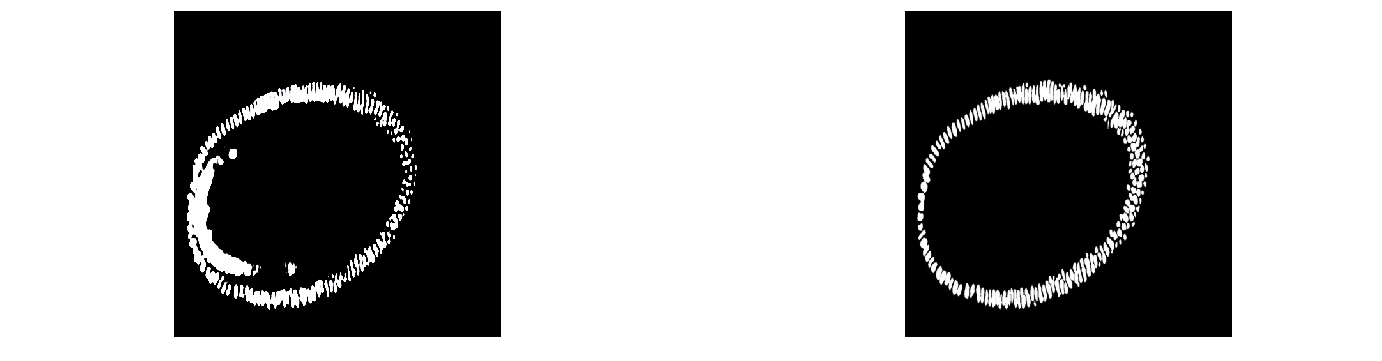

In [34]:
def show_n(img_files, n=6):
    _, ax = plt.subplots(1, n, sharex='col', sharey='row', figsize=(24,6))
    
    for i, img_file in enumerate(img_files):
        ax[i].imshow(img_file)
        ax[i].axis('off')
        
for pred,actual in zip(predicted_masks[40:60], actual_masks[40:60]):
    show_n([np.asarray(pred), np.asarray(actual)],n=2)

In [35]:
assert pred.mode == actual.mode

# Generating test predictions

In [36]:
BATCH_SIZE_INF = 8

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
#     transforms.Grayscale(),
    transforms.ToTensor()
])


test_transform_size = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = YvanImageFolder(os.path.join(DATA_PATH, 'test_img'), test_transform)
test_loader = data.DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE_INF,
                             shuffle=False,
                             num_workers=1)


test_sizes = YvanImageFolder(os.path.join(DATA_PATH, 'test_img'), test_transform_size)
test_sizes_loader = data.DataLoader(dataset=test_sizes,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

In [37]:
sizes_in_order = [tuple(batch[0].size()[2:]) for batch, paths in test_sizes_loader]

In [54]:
predicted_names = []
predicted_test = []
ct = 0

for batch, paths in test_loader:
    predicted_names += list(paths[0])
    image_batch = to_variable(batch[0])
    x = unet(image_batch)
    for i in x.data:
        size = sizes_in_order[ct]
        im = transforms.ToPILImage(mode='RGB')(i.cpu()).convert('L')
        im = im.resize((size[1], size[0]), resample=Image.NEAREST)
        predicted_test.append(im)
        ct += 1

In [55]:
for i in range(len(sizes_in_order)): 
    assert sizes_in_order[i] == np.asarray(predicted_test[i]).shape

# Make a submission

In [60]:
%reload_ext autoreload
from utils import *
from skimage.morphology import label

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encode(lab_img == i)
        
# https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    # if you dont transpose it scores 0!
    # this is bceause its top to bottomr first
    # then left to right so you gotta trnaspose.
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [61]:
import pandas as pd

test_names = []
test_rles = [] 
for i, (p, path) in enumerate(zip(predicted_test, predicted_names)):
    supposed_size = sizes_in_order[i]
    pred_slide = np.asarray(np.array(p)/255)
    name = os.path.splitext(os.path.basename(path))[0].split('_')[0]
    rles = list(prob_to_rles(pred_slide, cutoff=0.75))
    test_rles.extend(rles)
    test_names.extend([name]*len(rles))

In [62]:
sub = pd.DataFrame()
sub['ImageId'] = test_names
sub['EncodedPixels'] = pd.Series(test_rles)
# sub['EncodedPixels'] = pd.Series(test_rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.tail(n=15)

,ImageId,EncodedPixels
2720,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,21697 4 21953 5 22207 8 22462 9 22716 11 22972...
2721,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,9155 5 9410 7 9666 7 9920 9 10175 10 10431 10 ...
2722,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,19142 7 19398 8 19654 8 19910 8 20166 9 20422 ...
2723,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,27334 7 27590 8 27846 9 28102 9 28358 9 28614 ...
2724,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,30416 6 30671 9 30926 11 31181 12 31437 13 316...
2725,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15320 6 15575 8 15830 9 16086 10 16342 11 1659...
2726,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,26842 3 27096 8 27351 10 27606 11 27861 12 281...
2727,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,41437 2 41690 8 41945 10 42201 11 42457 12 427...
2728,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20965 6 21220 9 21476 10 21732 11 21988 11 222...
2729,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,7675 5 7927 10 8179 14 8433 16 8687 18 8943 17...


In [63]:
idt = 'fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f'
sub[sub['ImageId'] == idt].shape

(70, 2)

In [64]:
sub.to_csv(os.path.join(DATA_PATH, 'submissions','march62018_3.csv'), index=False)

LB 0.309 Used dice loss function and 3 color channels. I think it mad a difference.